# Analise Exploratória dos Dados

O notebook foi criado para que fosse realizada uma análise exploratória dos 
dados a serem utilizados no TG. Os dados a setem analisados são:

* Demanda energética real - ONS
* População por estado | região | Brasil
* PIB
* Índice de Industrialização
* Índice de Desemprego
* Histórico Climático

A análise se desdobrará nos seguintes tópicos:

1. Gráficos das séries históricas
2. Contabilização de dados faltantes
3. Extração dos componentes de Tendência e Sazonalidade
4. Adequação da Resolução dos indicadores
5. Estratégias para a previsão de Demanda


---

Fontes utilizadas para obtenção dos dados:

```json
    {
        "Demanda Elétrica": "http://www.ons.org.br/Paginas/resultados-da-operacao/historico-da-operacao/curva_carga_horaria.aspx" ,
        "PIB" : "https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9300-contas-nacionais-trimestrais.html?=&t=series-historicas",
        "População" : "https://www.ibge.gov.br/estatisticas/sociais/populacao/9109-projecao-da-populacao.html?=&t=resultados"
    }
```

---

# 0. Setup

Importação das *libraries* necessárias para a análise, bem como todos os 
*datasets* que serão utilizados.

In [101]:
import logging
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dataprep import create_df_resol_horaria, interpolate_final, season

In [2]:
# Config do Log

# logging.basicConfig(format="")
# logging.
# log = logging.getLogger(name="EDA_TG")
# log.setLevel(level="DEBUG")

In [3]:
# Paths
PRC_DATA = "../data/prc/"

In [4]:
# Importando as features a serem utilizadas pelo modelo
features = pd.read_parquet(f"{PRC_DATA}model.parquet")

In [8]:
print(" ===== Features ===== \n")
print(f"Shape original:\n{features.shape}\n\n")

_min = features["Datetime"].min()
_max = features["Datetime"].max()

print("Periodo:")
print(f"{_min.strftime('%Y-%m-%d')} - {_max.strftime('%Y-%m-%d')}\n\n")

print("Variaveis (features) disponíveis:")
print(f"{features.columns}\n\n")

features.head()

 ===== Features ===== 

Shape original:
(103880, 16)


Periodo:
2011-01-01 - 2022-11-17


Variaveis (features) disponíveis:
Index(['Datetime', 'Demand_Nordeste_MWh', 'Demand_Norte_MWh',
       'Demand_Sudeste_CentroOeste_MWh', 'Demand_Sul_MWh', 'Export_MM_Reais',
       'Import_MM_Reais', 'PIB_MM_Reais', 'PIB_Growth_Perc',
       'Population_Centro-Oeste_hab', 'Population_Nordeste_hab',
       'Population_Norte_hab', 'Population_Sudeste_hab', 'Population_Sul_hab',
       'Population_Brasil_hab', 'Demand_Brasil_MWh'],
      dtype='object')




,Datetime,Demand_Nordeste_MWh,Demand_Norte_MWh,Demand_Sudeste_CentroOeste_MWh,Demand_Sul_MWh,Export_MM_Reais,Import_MM_Reais,PIB_MM_Reais,PIB_Growth_Perc,Population_Centro-Oeste_hab,Population_Nordeste_hab,Population_Norte_hab,Population_Sudeste_hab,Population_Sul_hab,Population_Brasil_hab,Demand_Brasil_MWh
index,,,,,,,,,,,,,,,,
0,2011-01-01 00:00:00,7496.0,3876.0,26950.0,7145.0,103744.0000,116374.000000,1.016531e+06,6.600000,14455893,54387140,16367015,82494774,28026430,195731254,45467.0
1,2011-01-01 01:00:00,7187.0,3794.0,26406.0,6998.0,103753.8375,116380.748611,1.016563e+06,6.599537,14455917,54387175,16367042,82494853,28026456,195731446,44385.0
2,2011-01-01 02:00:00,7091.0,3788.0,25368.0,6598.0,103763.6750,116387.497222,1.016596e+06,6.599074,14455942,54387211,16367069,82494933,28026481,195731638,42845.0
3,2011-01-01 03:00:00,6993.0,3759.0,24452.0,6253.0,103773.5125,116394.245833,1.016628e+06,6.598611,14455966,54387246,16367096,82495013,28026507,195731830,41457.0
4,2011-01-01 04:00:00,6861.0,3662.0,23879.0,6048.0,103783.3500,116400.994444,1.016661e+06,6.598148,14455991,54387281,16367122,82495093,28026533,195732022,40450.0


# 1 Gráficos das séries históricas

Gráficos a serem analisados:

1. **Lineplot** da demanda horária por Substistema para os últimos 5 dias.  
2. **Boxplot** da demanda horária por subsistema para o período inteiro.  
3. **Boxplot** da demanda horária por 'Season' e subsistema para o período inteiro.  
4. **Lineplot** dos índices do IBGE  
5. **Lineplot** dos índices do IBOVESPA  [Ainda não incluido]

--- 

## 1.1 **Lineplot** da demanda horária por Substistema para os últimos 5 dias.  


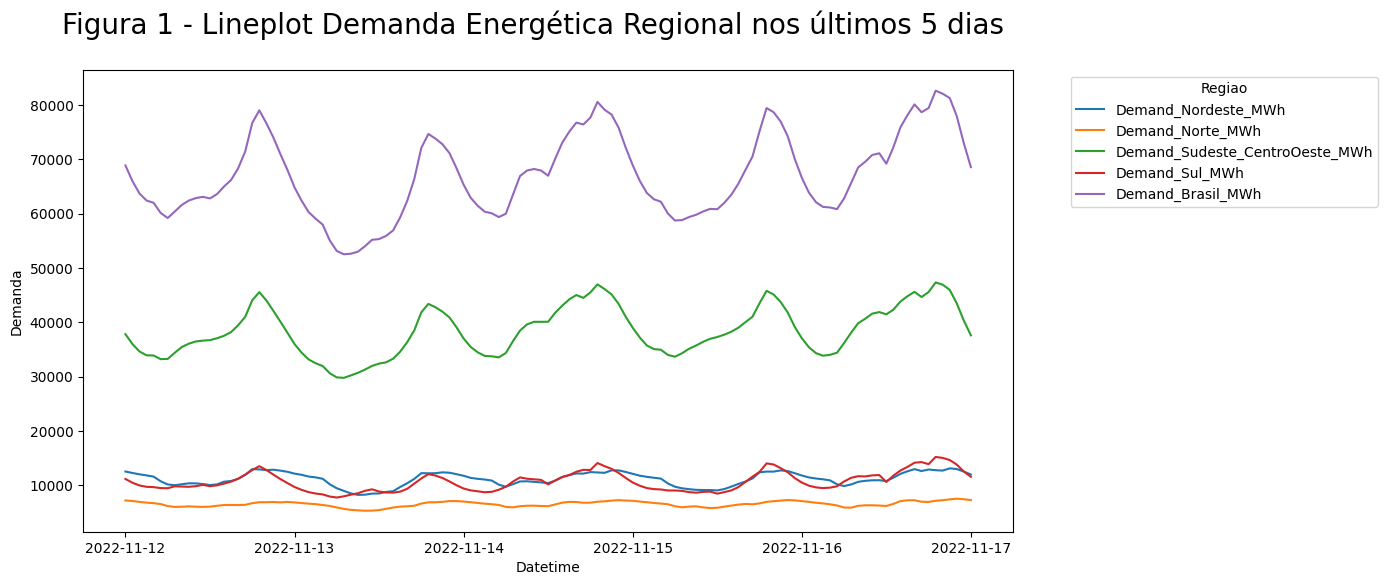

In [178]:
# Dataframe preparation
period = pd.date_range(start="2022-11-12", end="2022-11-17", freq="H")
subsystems = [sub for sub in features.columns if "Demand" in sub]

choosed_period =  features["Datetime"].isin(period)    
tmp_dem = features[choosed_period][["Datetime"] + subsystems].copy()
tmp_dem = tmp_dem.melt(id_vars="Datetime", var_name="Regiao", value_name="Demanda")

# Figure config
_fig_rows=1
_fig_cols=1

fig, axes = plt.subplots(_fig_rows, _fig_cols, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)

fig.suptitle("Figura 1 - Lineplot Demanda Energética Regional nos últimos 5 dias", fontsize=20)

# axes.set_title(f" do dataset")

# Ploting
sns.lineplot(
    ax=axes, data=tmp_dem, x="Datetime", y="Demanda", hue="Regiao"
)

sns.move_legend(axes, "upper right", bbox_to_anchor=(1.4, 1))


**Considerações**

Os últimos 5 dias de período da demanda, refletem uma sazonalidade típica para todas os submercados do Brasil. 

Como Sudeste/Centro-Oeste possuem as maiores demandas, o nível nacional os acompanha em tendência e sazonalidade.

A região com menor índice de variação, com uma linha quase '*flat*', é a do submercado Norte, apresentando também os menores valores de demanda.

---

## 1.2 **Boxplot** da demanda horária por subsistema para o período inteiro.  

In [ ]:
# Criação da feature "Hour"
features["Hour"] = features["Datetime"].dt.strftime("%H").astype(int)

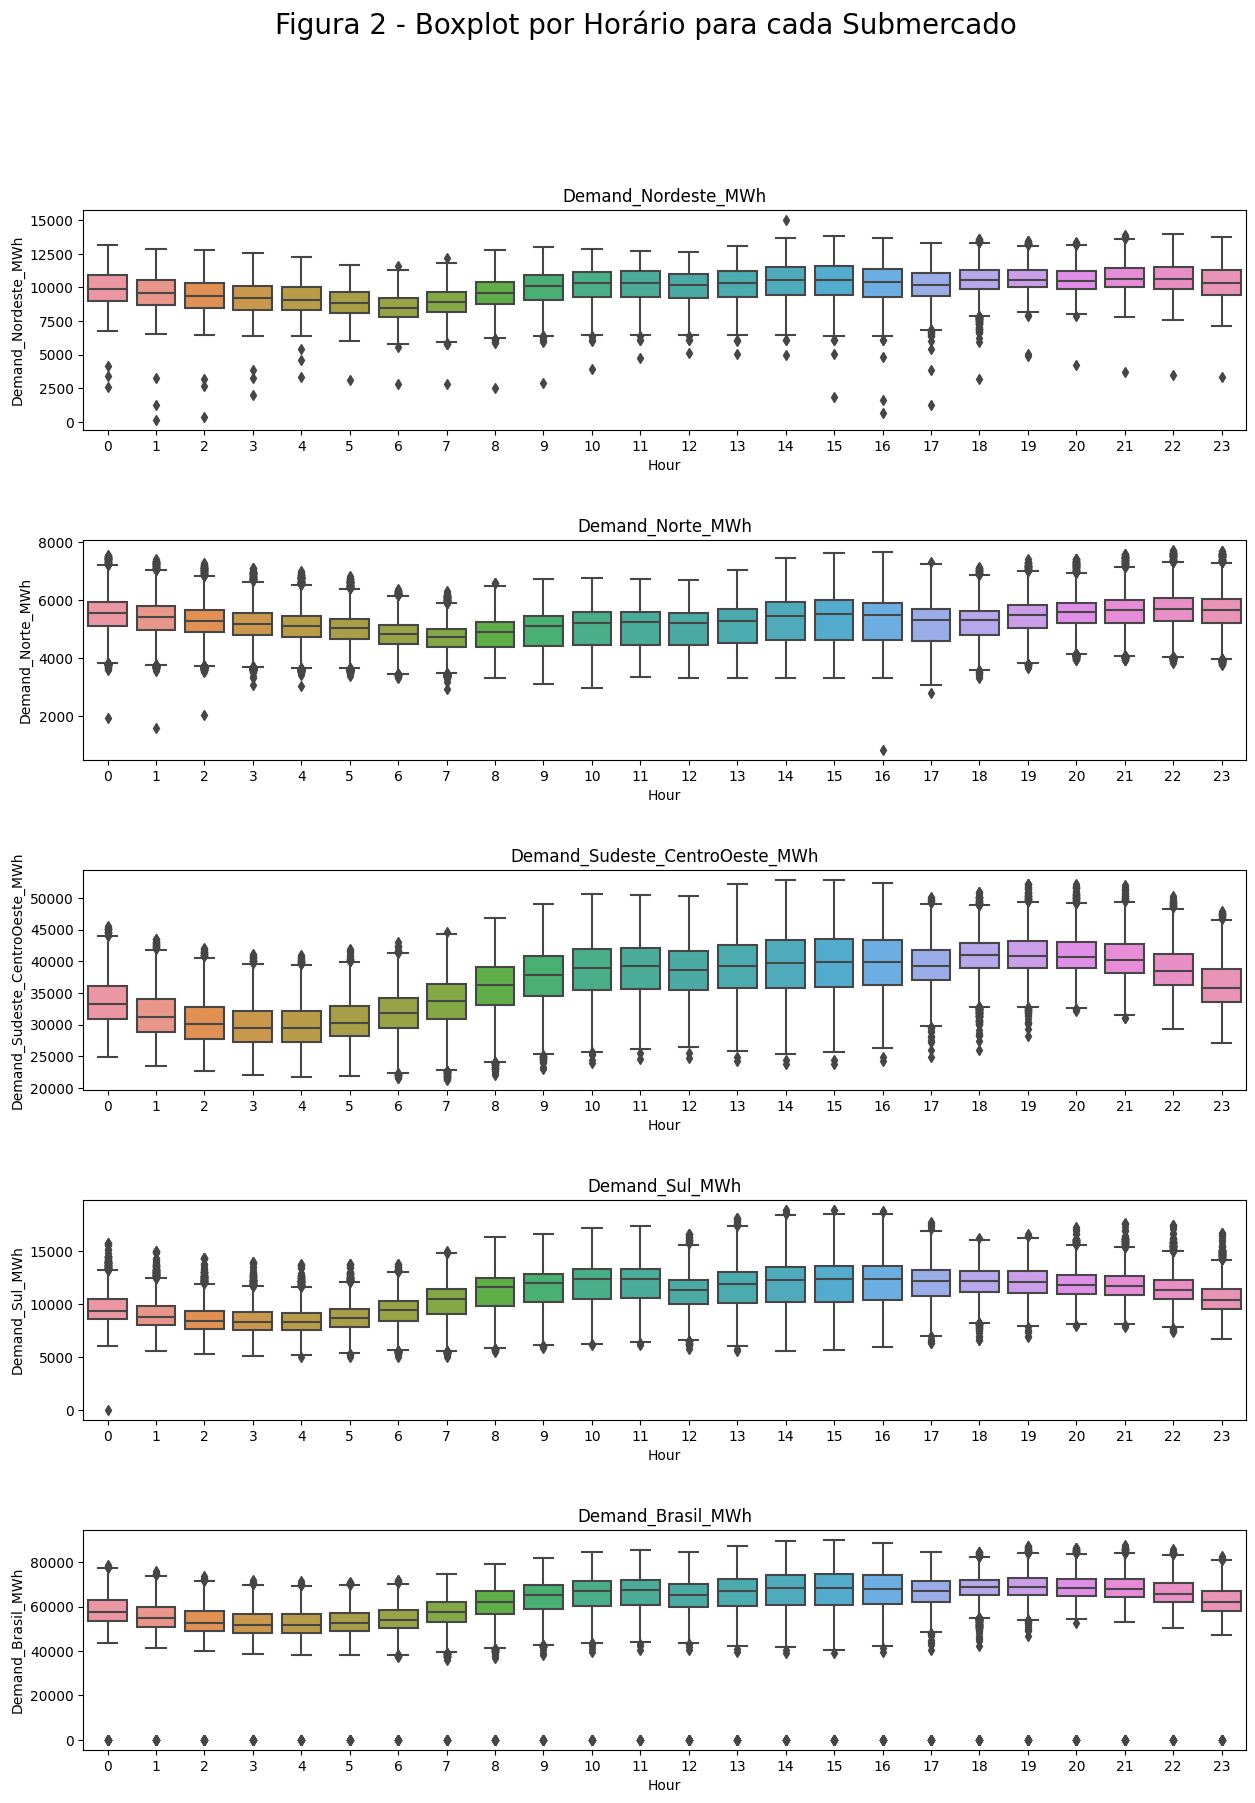

In [171]:
# Data prep
subsystems = [sub for sub in features.columns if "Demand" in sub]
hours = features["Hour"].unique()

# Fig config
_fig_rows = len(subsystems)
_fig_cols = 1

fig, axes = plt.subplots(_fig_rows, _fig_cols, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Figura 2 - Boxplot por Horário para cada Submercado", fontsize=20)

# Plot
count= 0

for subsystem in subsystems:

    axes[count].set_title(f"{subsystem}")

    sns.boxplot(
        ax=axes[count], 
        data=features,
        x="Hour",
        y=subsystem
    )

    count += 1

**Considerações**

Os horários do dia também influenciam na demanda para cada uma das regiões, ficando mais evidente principalmente nos submercados Sudeste/Centro-Oeste (mínimo as 3h e máximo as 19h) e Sul (mínimo as 3h e máximo as 16h)

Outro ponto a se destacar é a quantidade de *outliers* presente nos nas extremidades do horário comercial (8h - 18h). Isso pode impactar as previsões em diferentes horários.

No ano de 2018 o horário de verão foi retirado de circulação, porém, em dados passados, essa pode ser uma variável importante a se considerar, podendo o gráfico acima possuir variações inerentes a esse fator.



---

## 1.3 **Boxplot** da demanda horária por 'Season' e subsistema para o período inteiro.  

In [155]:
features["Season"] = season(features["Datetime"])

summer_pre {'start': '01-01', 'end': '03-20'}
autumn {'start': '03-21', 'end': '06-20'}
winter {'start': '06-21', 'end': '09-22'}
spring {'start': '09-23', 'end': '12-20'}
summer_post {'start': '12-21', 'end': '12-31'}


In [157]:
features["Season"].value_counts(dropna=False)

winter    27072
autumn    26496
summer    25475
spring    24837
Name: Season, dtype: int64

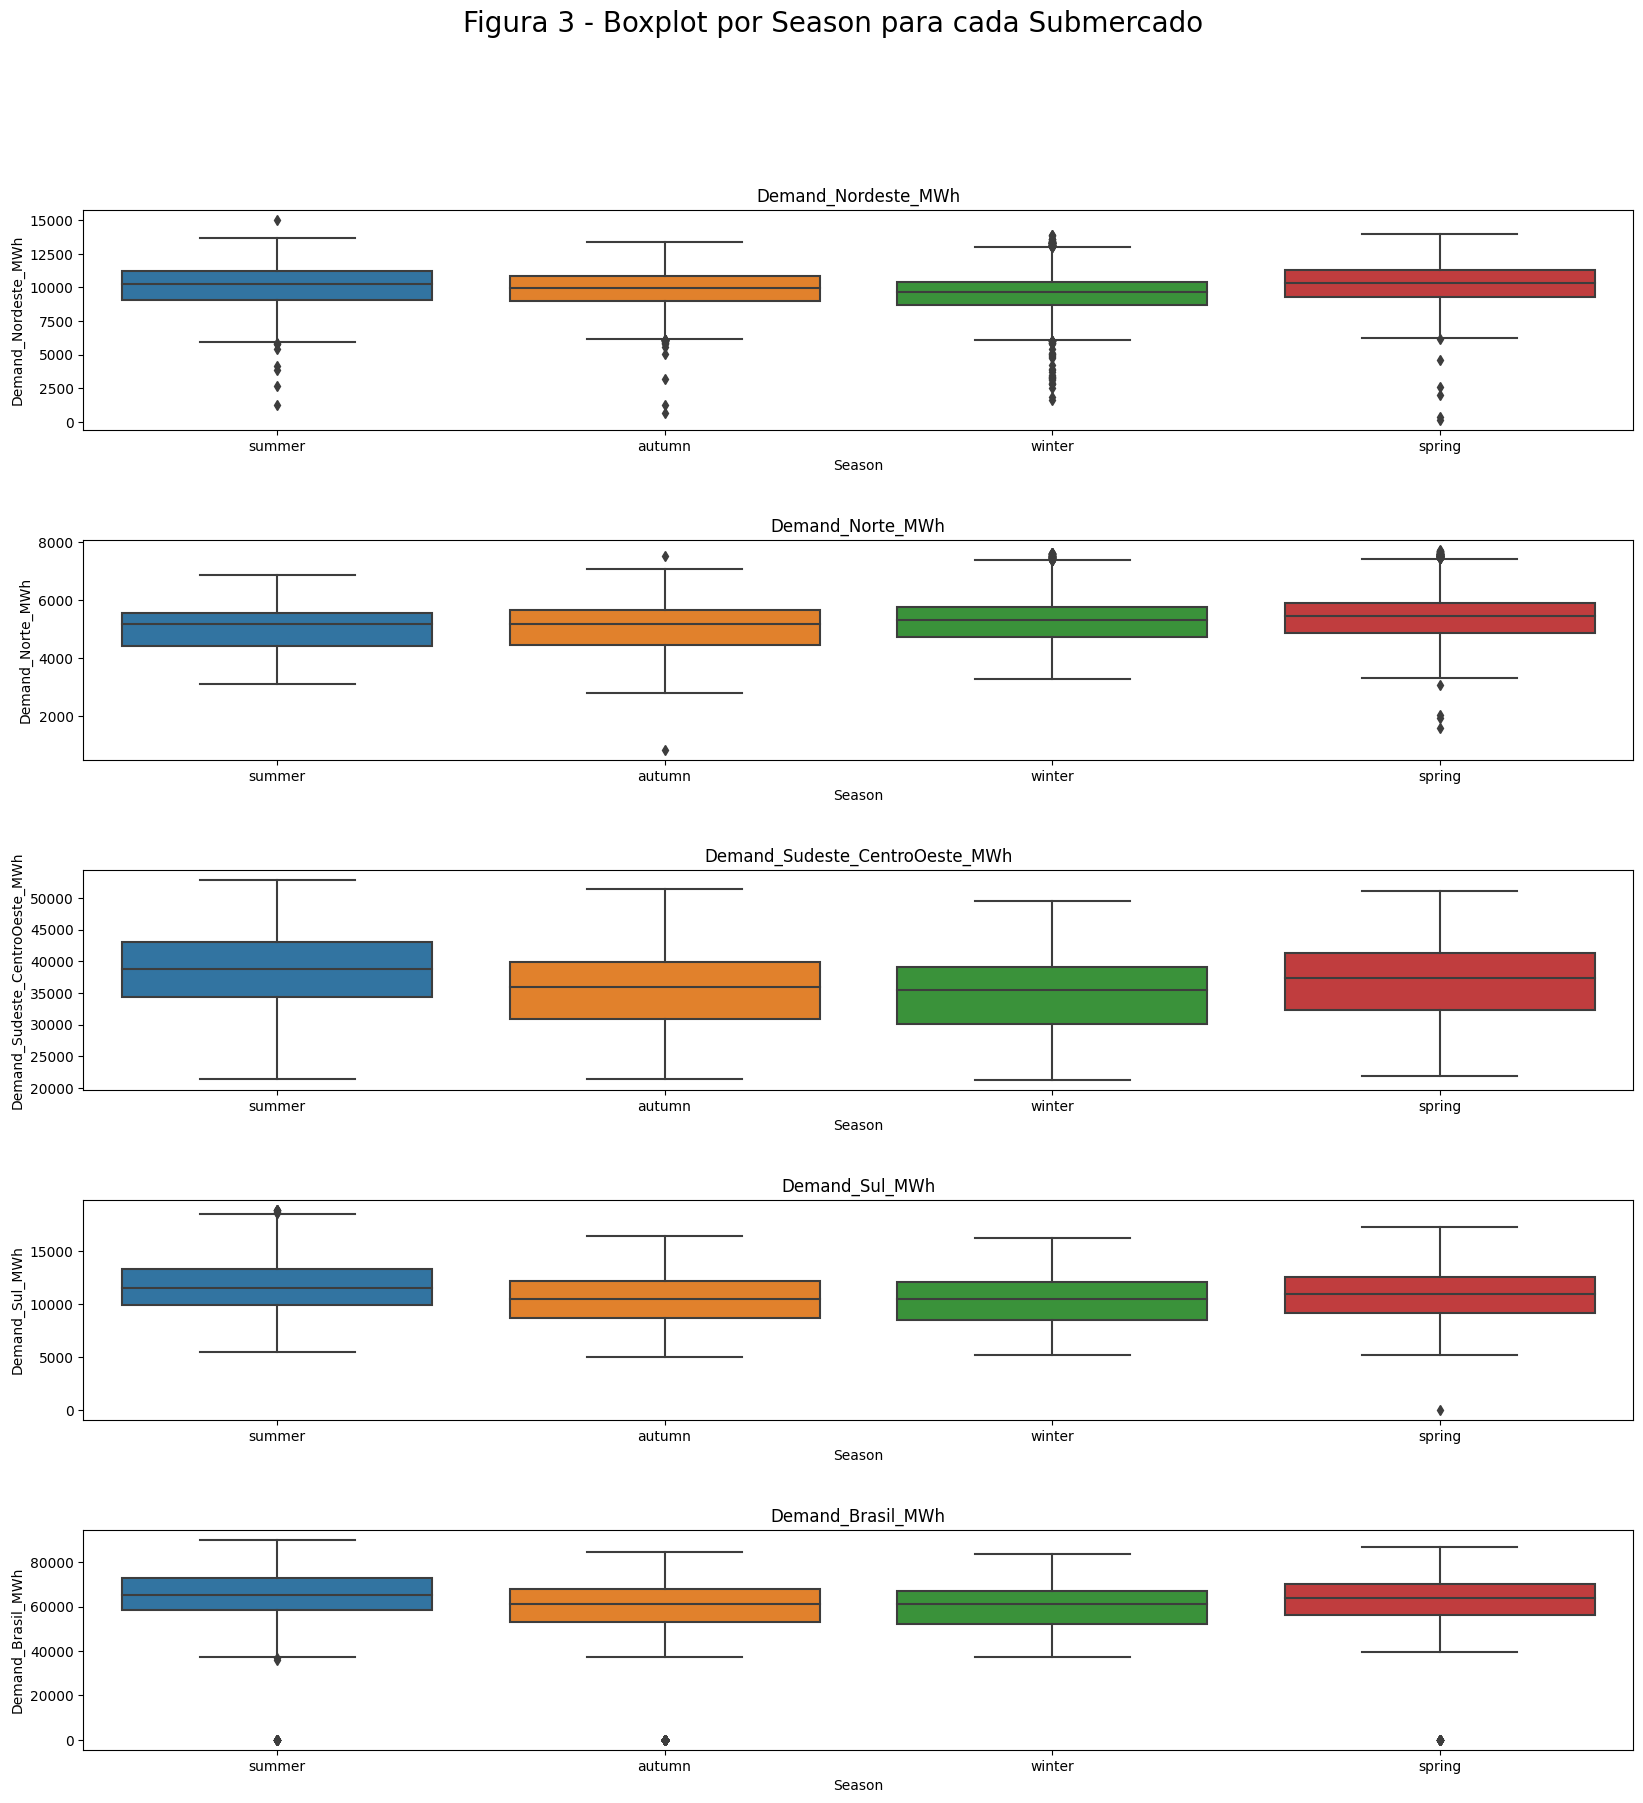

In [179]:
# Data prep
subsystems = [sub for sub in features.columns if "Demand" in sub]
seasons = features["Season"].unique()

# Fig config
_fig_rows = len(subsystems)
_fig_cols = 1

fig, axes = plt.subplots(_fig_rows, _fig_cols, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Figura 3 - Boxplot por Season para cada Submercado", fontsize=20)


# Plot
count= 0

for subsystem in subsystems:

    axes[count].set_title(f"{subsystem}")

    sns.boxplot(
        ax=axes[count], 
        data=features,
        x="Season",
        y=subsystem
    )

    count += 1

**Considerações**

Há pouca ou nenhuma variação da demanda elétrica quando feita a comparação por Estação do ano. Como nas outras variáveis, as regiões que possuem maior variação, continua sendo a região Sudeste/Centro-Oeste.

---

## 1.4 **Lineplot** dos índices do IBGE  

### 1.4.1 População

População estimada pelo IBGE para o tempo de demanda disponível para o treinamento do modelo.

In [164]:
# Dataprep
regions = [reg for reg in features.columns if "Population" in reg]

tmp_pop = features[["Datetime"] + regions].copy()
tmp_pop = tmp_pop.melt(id_vars="Datetime", var_name="Regiao", value_name="Populacao")


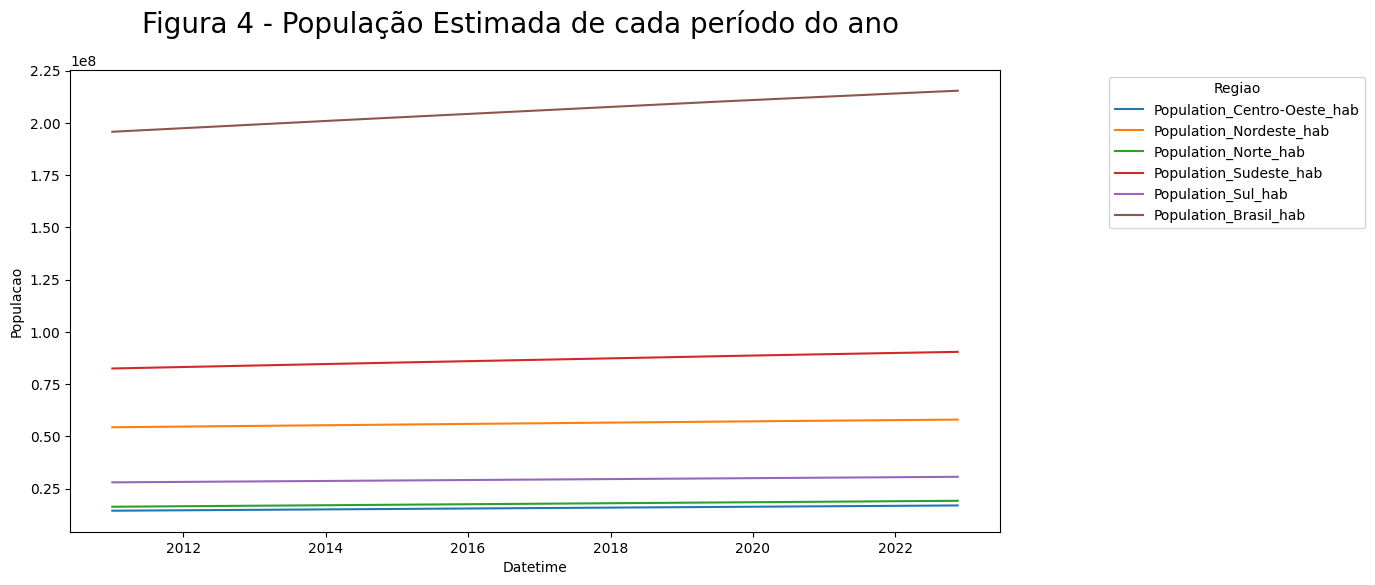

In [180]:
# Figure config
_fig_rows=1
_fig_cols=1

fig, axes = plt.subplots(_fig_rows, _fig_cols, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle(
    "Figura 4 - População Estimada de cada período do ano", fontsize=20
)

# Ploting
sns.lineplot(
    ax=axes, data=tmp_pop, x="Datetime", y="Populacao", hue="Regiao"
)

sns.move_legend(axes, "upper right", bbox_to_anchor=(1.4, 1))


**Considerações**

Crescimento da população dá-se em um ritmo muito lento, com pouca ou nenhuma variação entre um ano e outro.

Acredita-se que não será uma boa variável para a estimativa de crescimento da demanda ao longo tempo nas regiões ou no Brasil.

---

### 1.4.2 PIB

Produto Interno Bruto (PIB) marcado pelo IBGE para o tempo de demanda disponível para o treinamento do modelo. Vale ressaltar que sua resolução original é trimestral e os pontos faltantes foram preenchidos através de interpolação linear.

In [183]:
# Dataprep
pibs = [pib for pib in features.columns if "PIB" in pib]

tmp_pibs = features[["Datetime"] + pibs].copy()
tmp_pibs = tmp_pibs.melt(id_vars="Datetime", var_name="Medidor", value_name="PIB")


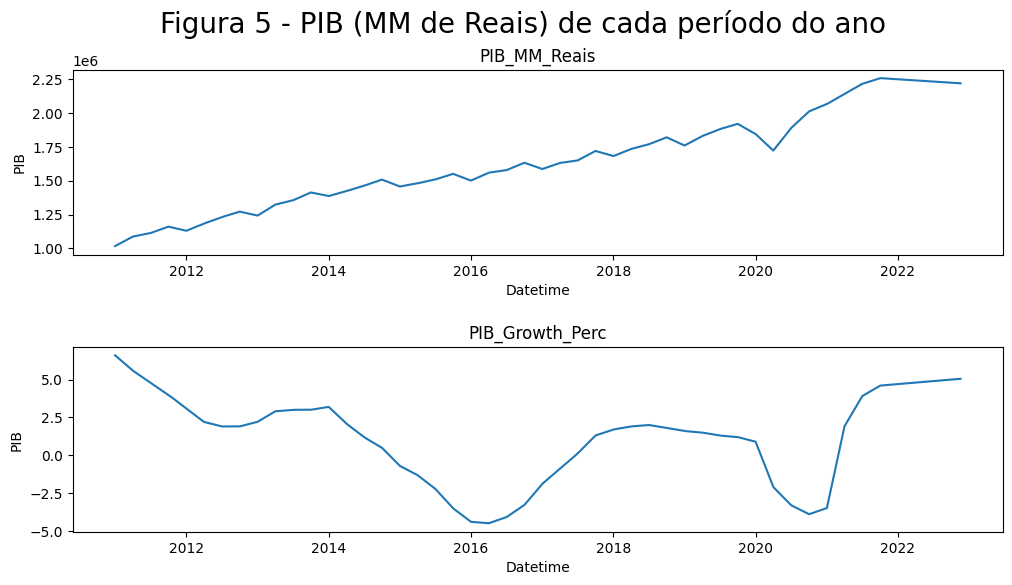

In [187]:
# Figure config
_fig_rows=len(pibs)
_fig_cols=1

fig, axes = plt.subplots(_fig_rows, _fig_cols, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle(
    "Figura 5 - PIB (MM de Reais) de cada período do ano", fontsize=20
)

# Ploting
count=0

for pib in pibs:
    
    sns.lineplot(
        ax=axes[count], data=tmp_pibs[tmp_pibs["Medidor"]==pib], 
        x="Datetime", y="PIB"
    )

    axes[count].set_title(f"{pib}")
    count += 1

**Considerações**

Há uma clara tendência de crescimento quando verifica-se a linha resultante do PIB do país, calculado em Trilhões de reais.

Embora haja uma tendência de crescimento explícito, dado pela série PIB_MM_Reais, a taxa percentual de crescimento do PIB não segue a mesma tendência.

Existe a possibilidade de se retirar a '*PIB_GROWTH_PERC*' como variável para o modelo, podendo induzir ao erro.

---

### 1.4.3 Importações e Exportações

Valor corrente das importações e Exportações por setor da economia.

In [189]:
# Dataprep
imp_exp = ['Export_MM_Reais', 'Import_MM_Reais']

tmp_imp_exp = features[["Datetime"] + imp_exp].copy()
tmp_imp_exp = tmp_imp_exp.melt(
    id_vars="Datetime", var_name="Tipo", value_name="MM_Reais"
)


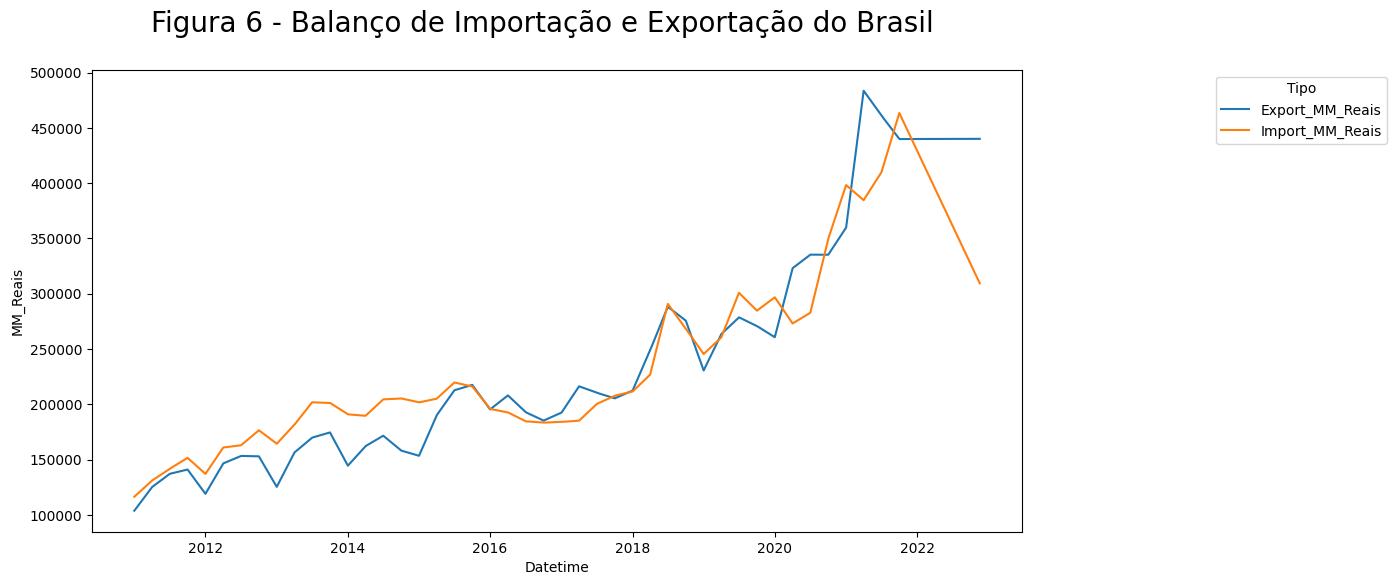

In [190]:
# Figure config
_fig_rows=1
_fig_cols=1

fig, axes = plt.subplots(_fig_rows, _fig_cols, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle(
    "Figura 6 - Balanço de Importação e Exportação do Brasil", fontsize=20
)

# Ploting
sns.lineplot(
    ax=axes, data=tmp_imp_exp, x="Datetime", y="MM_Reais", hue="Tipo"
)

sns.move_legend(axes, "upper right", bbox_to_anchor=(1.4, 1))


**Considerações**

Há uma clara tendência de crescimento para ambas as linhas do balanço de importações e exportações do país.

Série que pode ser correlacionada ao PIB do país.

---

# 2 Extração dos componentes de Tendência e Sazonalidade

Nessa etapa, serão extraídos os componentes das séries visualizadas anteriormente para verificação de tendência, sazonalidade, ciclo e resíduos totais.

In [192]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [240]:
ts_dem_brasil = features[choosed_period][["Datetime", "Demand_Brasil_MWh"]].copy()
ts_dem_brasil.set_index("Datetime", inplace=True)

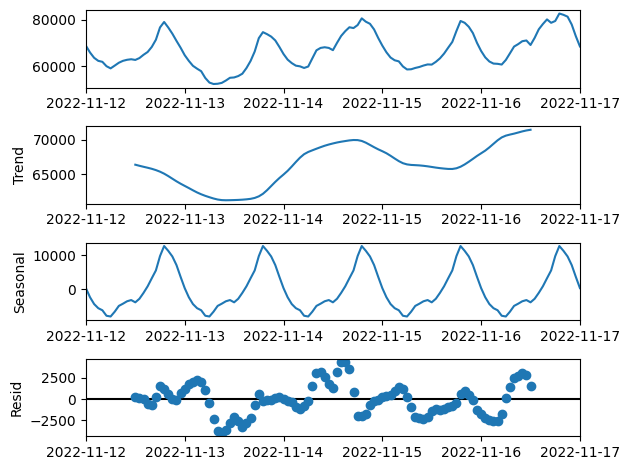

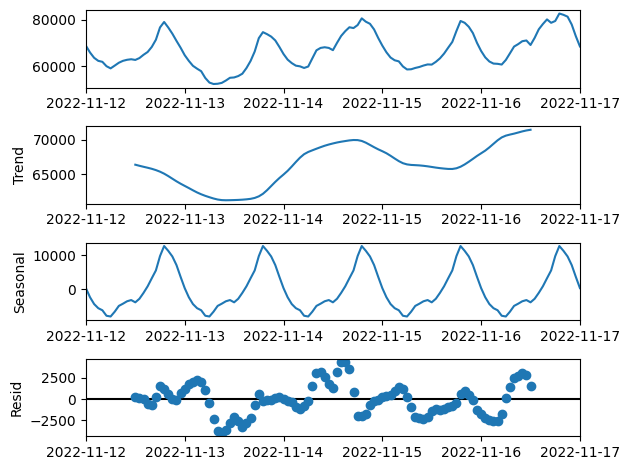

In [243]:
sd = seasonal_decompose(ts_dem_brasil, model="additive")
sd.plot()

**Considerações**

Embora o método por decomposição usando o método aditivo consiga mostrar uma sazonalidade e uma linha de tendência, apresenta resíduos com valores muito altos.

<AxesSubplot: >

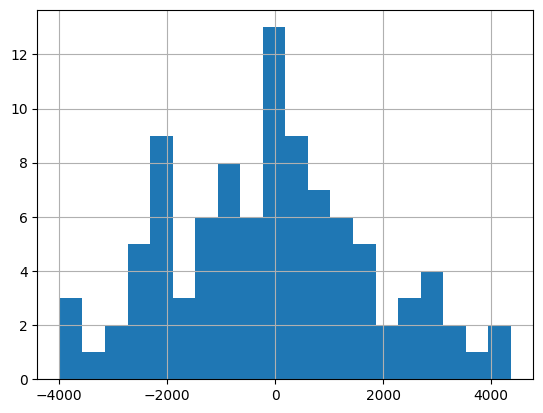

In [249]:
sd.resid.hist(bins=20)

Os valores dos resíduos podem conter uma sazonalidade não obtida pelo modelo, embora sua distribuição se pareça com uma normal centrada em zero com um desvio padrão controlado.

<AxesSubplot: >

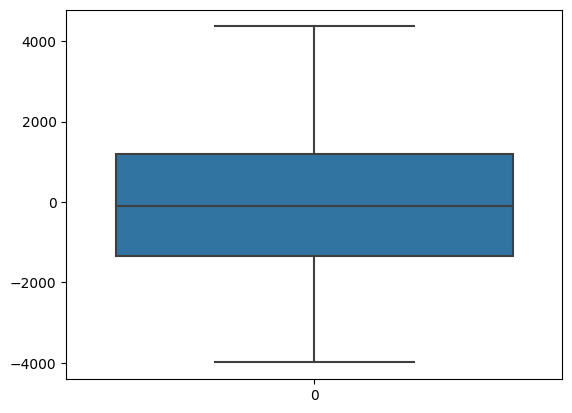

In [252]:
sns.boxplot(sd.resid)

# 3 Adequação da Resolução dos indicadores

Seção dedicada ao trabalho de adequação da resolução dos indicadores do IBGE em uma frequência horária. Embora os indicadores tenham medições ou estimativas mensais e trimestrais, foi-se utilizado o método de interpolação para o preenchimento dos valores.  

Ou seja, entre dois pontos mensais/trimestrais calcula-se a diferença entre ambos e divide-se pela quantidade de tempo entre eles, encontrando-se assim o passo correspondente por unidade de tempo desejada.

## 3.1 PIB

In [ ]:
pib = pd.read_parquet(f"{PRC_DATA}pib.parquet")

print("Shape original:", pib.shape)
pib.head()

In [ ]:
_num_cols = [col for col in pib.columns if col not in ["Datetime"]]
pib_horario = create_df_resol_horaria(pib, _num_cols)

## 3.2 População

In [ ]:
# Leitura
pop_brasil = pd.read_parquet(f"{PRC_DATA}pop_total.parquet")
pop_uf = pd.read_parquet(f"{PRC_DATA}pop_uf.parquet")
pop_region = pd.read_parquet(f"{PRC_DATA}pop_region.parquet")

Brasil

In [ ]:
pop_brasil = pop_brasil.pivot(
    index="Datetime", columns="Region", values="Population_hab"
).reset_index()

In [ ]:
_num_cols = [col for col in pop_brasil.columns if col not in ["Datetime"]]
pop_brasil_horario = create_df_resol_horaria(pop_brasil, _num_cols)

Regiões do Brasil

In [ ]:
# Pivot 
pop_region = pop_region.pivot(
    index="Datetime", columns="Region", values="Population_hab"
).reset_index()

In [ ]:
_num_cols = [col for col in pop_region.columns if col not in ["Datetime"]]
pop_reg_horario = create_df_resol_horaria(pop_region, _num_cols)

Brasil + Regiões do Brasil

In [ ]:
# Merge dos dois indicadores de PIB
pop_horario = pd.merge(
    left=pop_reg_horario, 
    right=pop_brasil_horario, 
    on="Datetime", 
    how="left"
)

print(f"Shape original: {pop_horario.shape}\n")
pop_horario.head()

In [ ]:
# Transformando o tipo para inteiro
_num_cols = [col for col in pop_horario.columns if col not in ["Datetime"]]
pop_horario[_num_cols] = pop_horario[_num_cols].astype("int64")

In [ ]:
# Renomeando colunas
pop_horario.columns= ["Datetime"] + \
    ["Population_"+col+"_hab" for col in pop_horario.columns if col != "Datetime"]

In [ ]:
pop_horario

In [ ]:
# Export 
pop_horario.to_parquet(f"{PRC_DATA}pop_horario.parquet")

## 3.3 União

In [ ]:
demanda_eletrica.describe().transpose()

In [ ]:
model_dataset = pd.merge(demanda_eletrica, pib_horario, on="Datetime", how="left")
model_dataset = pd.merge(model_dataset, pop_horario, on="Datetime", how="left")

In [ ]:
_intepol_cols = [
    'Export_MM_Reais', 'Import_MM_Reais', 'PIB_MM_Reais', 'PIB_Growth_Perc'
]
for col in _intepol_cols:
    model_dataset[col] = interpolate_final(serie=model_dataset[col])

In [ ]:
_dem_cols = [col for col in model_dataset.columns if "Demand" in col]
model_dataset["Demand_Brasil_MWh"] = model_dataset[_dem_cols].sum(axis=1)

In [ ]:
model_dataset.to_parquet(f"{PRC_DATA}model.parquet")